In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch

from src.get_data import collect_data_from_matches

from src.model_building import build_graph_from_frame, TemporalRunnerDataset, TemporalRunnerGNN, train_model, collate_fn, predict_optimal_run, evaluate_all_runs

from src.visualization_tools import plot_soccer_pitch
from src.visualization_tools import animate_run
from src.visualization_tools import plot_spatial_graph
from src.visualization_tools import plot_optimal_run

# Load Data

In [2]:
matches = [1886347]
possessions, run_features, tracking_data, player_to_team, merged = collect_data_from_matches(matches)


100%|██████████| 1/1 [00:40<00:00, 40.99s/it]


In [3]:
run_types_to_predict = ['cross_receiver','behind',"overlap","support","coming_short"]
runs_to_predict = merged[merged.event_subtype.isin(run_types_to_predict)]

In [4]:
tracking_frame_groups = {
    (mid, rid): df
    for (mid, rid), df in tracking_data.groupby(
        ["match_id", "run_id"]
    )
}

# Validating that we can build graphs for each run

In [5]:
def validate_run(run_row):
    runner_id = run_row["player_id"]
    match_id = run_row["match_id"]
    run_id = run_row["event_id"]

    frame_start = int(run_row["frame_start_run"])
    frame_end = int(run_row["frame_end_run"])

    tracking = tracking_frame_groups[(match_id, run_id)]

    lower_frame = max(frame_start-10,tracking["frame_id"].min())
    
    expected_frames = set(range(lower_frame, frame_end + 1))
    actual_frames = set(tracking["frame_id"].unique().tolist())

    if not expected_frames.issubset(actual_frames):
        return False
    
    runner_per_frame = (
        tracking
        .groupby("frame_id")["player"]
        .apply(lambda players: runner_id in players.values)
    )
    return runner_per_frame.all()
runs_to_predict = runs_to_predict[runs_to_predict.apply(validate_run,axis=1)]

In [6]:
runs_to_predict_test = runs_to_predict.sample(frac=.2, replace = False, random_state = 42)

runs_to_predict_train = runs_to_predict.drop(runs_to_predict_test.index)

<Axes: >

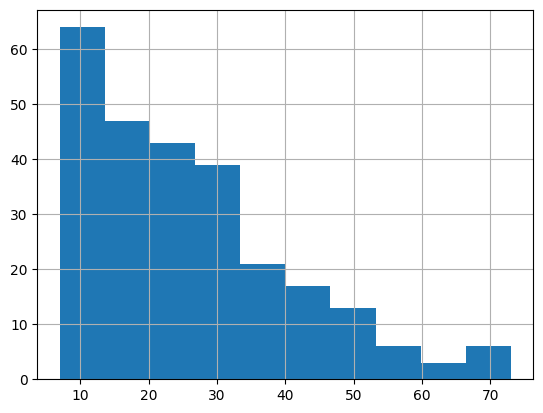

In [7]:
(runs_to_predict["frame_end_run"] - runs_to_predict["frame_start_run"]).hist()

# Build Graph

In [8]:
RUN_NUM = 0
RUN_FRAME = 2
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]

run_tracking = tracking_data[(tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()
frame_num = run_tracking["frame_id"].sort_values().iloc[0] + RUN_FRAME
frame_df = run_tracking[run_tracking["frame_id"]==frame_num]


graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=player,player_to_team=player_to_team)
graph

Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=19, team_ids=[23], is_ball=[23])

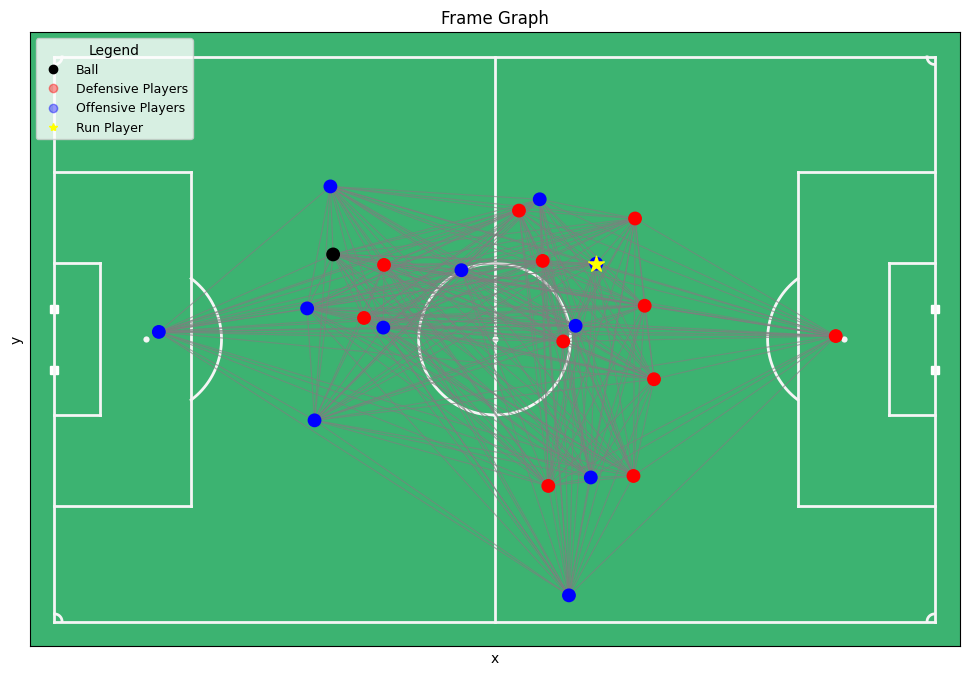

In [9]:
%matplotlib inline
plot_spatial_graph(graph)

# Temporal Dataset class

In [10]:
dataset = TemporalRunnerDataset(
    tracking_df=tracking_frame_groups,
    run_features=runs_to_predict_train,
    player_to_team=player_to_team,
)
dataset

# Temporal GNN

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

node_feat_dim = 10
edge_dim = 4
gnn_hidden_dim = 64   

model = TemporalRunnerGNN(node_feat_dim,edge_dim,gnn_hidden_dim).to(device)

# Training Loop

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)

model = train_model(model,device = device, dataloader=dataloader,num_epochs=10,output_file="temporal_runner_more_types.pth")


# Load Model From Saved State

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

node_feat_dim = 10
edge_dim = 4
gnn_hidden_dim = 64   

model = TemporalRunnerGNN(node_feat_dim,edge_dim,gnn_hidden_dim).to(device)
model.load_state_dict(torch.load("temporal_runner_more_types.pth",map_location=torch.device('cpu')))
model.to(device)
model.eval() 

TemporalRunnerGNN(
  (gnn1): TransformerConv(10, 64, heads=4)
  (gnn2): TransformerConv(64, 64, heads=4)
  (temporal_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pos_head): Linear(in_features=64, out_features=2, bias=True)
)

# Given tracking data and runner id predict optimal run path

In [14]:
model.eval()
T = 10
RUN_NUM = 50
run = runs_to_predict_train.iloc[RUN_NUM]
match_id = run['match_id']
run_id = run['event_id']
runner_id = run['player_id']
team_id = run["team_id"]

absolute_path = predict_optimal_run(run,model,tracking_frame_groups=tracking_frame_groups,device = device,player_to_team = player_to_team)
absolute_path = absolute_path.cpu()

# Plot Optimal Run Path

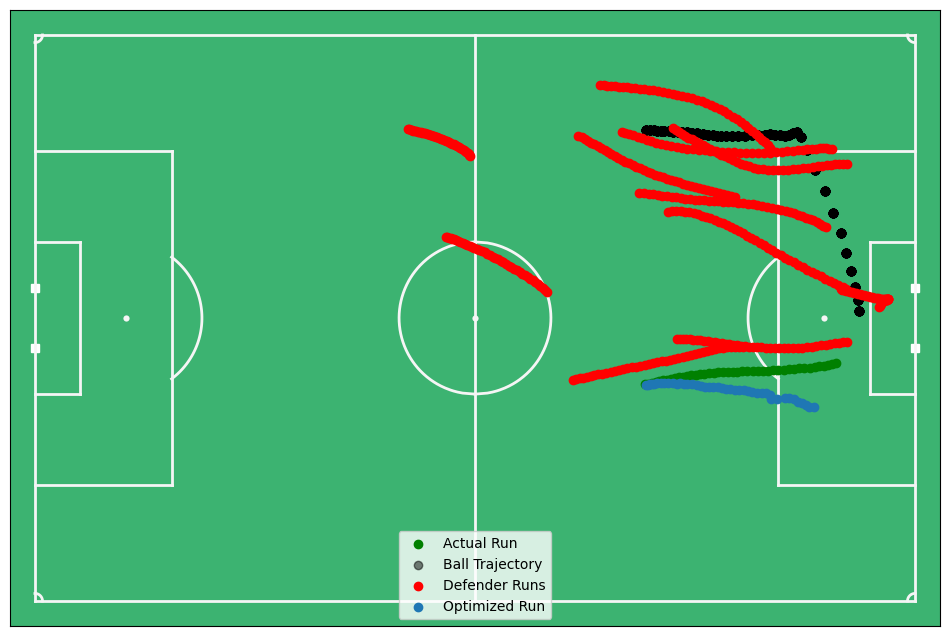

In [15]:
%matplotlib inline
plot_optimal_run(run,tracking_frame_groups=tracking_frame_groups,player_to_team=player_to_team,absolute_path=absolute_path)

37, 39

# Animate Optimal Run

In [16]:
# Transform for animation
run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')
pred_x = pd.Series(absolute_path[:,0])
pred_y = pd.Series(absolute_path[:,1])
dx = pred_x - pred_x.shift(1)
dy = pred_y - pred_y.shift(1)
s = np.sqrt(dx**2 + dy**2) * 10
d = np.arctan2(dy,dx)
pred_vals = pd.concat([pred_x,pred_y,dx,dy,s,d],axis=1)
pred_vals.columns = ["x","y","dx","dy","s","d"]
pred_vals["player"] = -1
pred_run = run_tracking[(run_tracking.run_active) & (run_tracking.player==runner_id)].copy()
pred_run.loc[:,["x","y","dx","dy","s","d","player"]] = pred_vals.fillna(0).values

In [17]:
%matplotlib tk

run_tracking_with_pred = pd.concat([run_tracking,pred_run])
ani = animate_run(run=run,tracking_data=run_tracking_with_pred,player_to_team=player_to_team)

# View run examples
run #s: 13, 17

In [17]:
test_eval_metrics = evaluate_all_runs(runs_to_predict_test,model,tracking_frame_groups,device,player_to_team)

In [18]:
train_eval_metrics = evaluate_all_runs(runs_to_predict_train,model,tracking_frame_groups,device,player_to_team)

In [19]:
test_eval_metrics = pd.DataFrame(test_eval_metrics)
train_eval_metrics = pd.DataFrame(train_eval_metrics)

In [20]:
test_means = test_eval_metrics[["loss_pos","loss_vel","loss_acc","possession_lead_to_shot"]].groupby("possession_lead_to_shot").mean()
train_means = train_eval_metrics[["loss_pos","loss_vel","loss_acc","possession_lead_to_shot"]].groupby("possession_lead_to_shot").mean()

test_means = test_means.add_prefix("test_")
train_means = train_means.add_prefix("train_")

combined = test_means.join(train_means, how="outer")[["test_loss_pos", "train_loss_pos", 
                                                     "test_loss_vel", "train_loss_vel", 
                                                     "test_loss_acc", "train_loss_acc"]]
combined

,test_loss_pos,train_loss_pos,test_loss_vel,train_loss_vel,test_loss_acc,train_loss_acc
possession_lead_to_shot,,,,,,
0,2.661467,2.452927,0.021991,0.023877,0.014063,0.012982
1,4.295046,3.133792,0.022152,0.019811,0.015558,0.016389


In [42]:
print(combined.to_markdown())

|   possession_lead_to_shot |   test_loss_pos |   train_loss_pos |   test_loss_vel |   train_loss_vel |   test_loss_acc |   train_loss_acc |
|--------------------------:|----------------:|-----------------:|----------------:|-----------------:|----------------:|-----------------:|
|                         0 |         2.66147 |          2.45293 |       0.0219908 |        0.0238774 |       0.0140634 |        0.0129822 |
|                         1 |         4.29505 |          3.13379 |       0.022152  |        0.0198112 |       0.0155577 |        0.0163894 |
